In [1]:
import os
# import colabdesign
# from colabdesign.mpnn import mk_mpnn_model, clear_mem
# from colabdesign.shared.protein import pdb_to_string
os.chdir('/home/gridsan/ylcho/')
import os
# import colabdesign
# from colabdesign.mpnn import mk_mpnn_model, clear_mem
# from colabdesign.shared.protein import pdb_to_string
os.chdir('/home/gridsan/ylcho/DMSV2/')
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
import tqdm.notebook
import seaborn
import re, tempfile
# from colabdesign.af.contrib import predictz
# from colabdesign.shared.protein import _np_rmsd

if "hhsuite" not in os.environ['PATH']:
    os.environ['PATH'] += ":/home/gridsan/ylcho/DMSV2/"
    
import sys
# sys.path.append('/home/gridsan/ylcho/DMSV2/source/')

# import source.pdbx as pdbx
# from pdbx.reader import PdbxReader
# from pdbx.reader.PdbxContainers import DataCategory
import gzip
import numpy as np
import torch
import os,sys
import glob
import re
from scipy.spatial import KDTree
from itertools import combinations,permutations
import tempfile
import subprocess

import torch
import pickle
import math


import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import tqdm.notebook
import seaborn
import re, tempfile
# from colabdesign.af.contrib import predictz
# from colabdesign.shared.protein import _np_rmsd

if "hhsuite" not in os.environ['PATH']:
    os.environ['PATH'] += ":/home/gridsan/ylcho/ProteinMPNN/MembraneMPNN"
    
import sys
sys.path.append('/home/gridsan/ylcho/ProteinMPNN/source/')

# import source.pdbx as pdbx
# from pdbx.reader import PdbxReader
# from pdbx.reader.PdbxContainers import DataCategory
import gzip
import numpy as np
import torch
import os,sys
import glob
import re
from scipy.spatial import KDTree
from itertools import combinations,permutations
import tempfile
import subprocess

import torch
import pickle
import math

import pandas as pd

In [24]:
import pandas as pd
from io import StringIO


file_path = 'dataset/50_masked_ESMFold_all_4_ptm_plddt_fromr10.txt'

ptm_list = []
plddt_list = []
with open(file_path, 'r') as file:
    for line in file:
        # Extract 'ptm' and 'plddt' values from each line
        ptm_value = float(line.split('ptm: ')[1].split(' plddt: ')[0])
        plddt_value = float(line.split('plddt: ')[1])

        # Append values to the lists
        ptm_list.append(ptm_value)
        plddt_list.append(plddt_value)

In [61]:
df1=pd.read_csv('dmsv2_aa_seq_all_4_plddt.csv')
df2=pd.read_csv('dmsv2_aa_seq_all_4_plddt_r10_r14.csv')
# Assuming you want to rename the 'plddt' column to 'new_name'
df2 = df2.rename(columns={'aa_seq': 'sequence', 'plddt': 'PLDDT'})
df2 = df2.drop(columns=['ptm'])
combined_df = pd.concat([df1, df2], axis=0)

In [63]:
# combined_df.to_csv('dmsv2_aa_seq_all_4_plddt_total.csv', index=False)

In [137]:
def dna_to_protein(dna_sequence):
    # Define the genetic code
    genetic_code = {
        'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
        'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
        'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
        'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
        'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
        'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
        'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
        'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
        'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
        'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
        'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
        'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
        'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
        'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
        'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
        'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
    }

    # Check if the length of the DNA sequence is a multiple of 3
    if len(dna_sequence) % 3 != 0:
        raise ValueError("DNA sequence length must be a multiple of 3")

    # Translate the DNA sequence to protein
    protein_sequence = ''
    for i in range(0, len(dna_sequence), 3):
        codon = dna_sequence[i:i+3]
        amino_acid = genetic_code.get(codon, 'X')  # 'X' for unknown or invalid codons
        protein_sequence += amino_acid

    return protein_sequence

In [126]:
df = pd.read_csv('dataset/230627_K50dG_dmsv2.csv')

In [127]:
print(" total unique pdb", len(np.unique(df['name'].str[:4].tolist())))

 total unique pdb 948


In [128]:
methods = {"TrROS":{},"TrMRF":{},"TrROS_Hall":{},"JUSTAS":{}}

In [129]:
filtered_df_1 = df[df['name'].str.contains('TrROS')]
chain_id_counts_1 = filtered_df_1['name'].value_counts()
print(len(chain_id_counts_1))

filtered_df_2 = df[df['name'].str.contains('TrMRF')]
chain_id_counts_2 = filtered_df_2['name'].value_counts()
print(len(chain_id_counts_2))

filtered_df_3 = df[df['name'].str.contains('TrROS_Hall')]
chain_id_counts_3 = filtered_df_3['name'].value_counts()
print(len(chain_id_counts_3))

filtered_df_4 = df[df['name'].str.contains('JUSTAS')]
chain_id_counts_4 = filtered_df_4['name'].value_counts()
print(len(chain_id_counts_4))

combined_df = pd.concat([filtered_df_1, filtered_df_2, filtered_df_3, filtered_df_4])

combined_df.reset_index(drop=True, inplace=True)

17198
12292
5754
11308


In [132]:
# len(combined_df)

In [134]:
df = pd.read_csv('dataset/230627_K50dG_dmsv2_refined.csv')[['name', 'log10_K50_t', 'log10_K50unfolded_t', 'deltaG_t', 'log10_K50_c', 'log10_K50unfolded_c', 'deltaG_c']] 

In [135]:
len(np.unique(combined_df['name'].tolist()))

40798

In [8]:
# df = pd.read_csv('230627_K50dG_dmsv2_refined.csv')

In [139]:
# df['aa_seq'] = df['dna_seq'].apply(dna_to_protein)

In [10]:
df = df[['name', 'aa_seq']]

In [13]:
df

,name,aa_seq
0,r1_0_TrROS,KLPPGFEIEKIKIEVNPDDGWIMVEYEIRMPGWEFEAEFMINPENG...
1,r1_2_TrROS,IRVPPGEWVQISIMIPFPAPPGEPIRIKFKIETANGEPMEVEYHYN...
2,r1_3_TrROS,KWKIRFQMPNGQPMEFPIEPYEMPDGEPKRYYRIKITNPNNGKPHE...
3,r1_4_TrROS,LDIEYDPDNGSFTVSFMVPIGPGHGVFVMVDYTFRFGPNGDIGIEW...
4,r1_5_TrROS,VKIEFKLPNGREFKIEVNPGWPMIPIKNPGTGRELMIMIYPNWIQI...
...,...,...
46547,r9_1232_JUSTAS,SMRYRIDITVPPEDPSVVTISVSPYTKDPNSSATLPTFTLEEVKAA...
46548,r9_1234_JUSTAS,SGVMSTETEVTVETSLTPDPTDPNLLTVNTTTTTTTTTTLVDPSNP...
46549,r9_1235_JUSTAS,SGMLYLYVVTRRSPLGGERPVIVVGTDPEKLKAEAAEAGWEMERFE...
46550,r9_1236_JUSTAS,SDLSSLASLGPNATRELEFRFEFTDPNSDTVVSSVKVTIRVTKTPE...


In [140]:
df = pd.read_csv('dmsv2_aa_seq_all_4.csv')

In [142]:
len(df)

8784

In [15]:
# df.to_csv('dmsv2_aa_seq_all_4_2.csv', index=False)

In [ ]:
name, sequence, k_T_1, A_T_1, rms_T_1, k_C_1, A_C_1, rms_C_1, aa_seq

## Raw txt file 

name,plddt,pae_intra,pae_inter,kc,kt

In [144]:
# Open the file in read mode
with open('raw.txt', 'r') as file:
    # Read all lines into a list
    lines_list = [[line.strip()] for line in file.readlines()]

In [164]:
import pandas as pd

# Sample DataFrame
df_orig = pd.read_csv('dmsv2_aa_seq.csv')

df = df_orig.drop_duplicates(subset=['name', 'aa_seq'])

# Create a dictionary to store proteins with the same prefix
protein_dict = {}

# Iterate through each protein ID
for protein_id in df['name']:
    tmp = protein_id.split("_")
    prefix, method = "_".join(tmp[:2]), "_".join(tmp[2:])
    
    # Check if the prefix is already a key in the dictionary
    if prefix in protein_dict:
        protein_dict[prefix].append(protein_id)
    else:
        protein_dict[prefix] = [protein_id]

# Filter the dictionary to keep only entries with exactly four items in the list
filtered_protein_dict = {key: value for key, value in protein_dict.items() if len(value) == 4}

# Flatten the list of proteins from the filtered dictionary


filtered_proteins = [protein for proteins in filtered_protein_dict.values() for protein in proteins]

# Filter the original DataFrame based on the filtered proteins
df_filtered = df[df['name'].isin(filtered_proteins)]

# print(len(df_filtered))

# def is_valid_name(name):
#     return name.startswith('r') and any(char.isdigit() for char in name[1:])

# # Filter rows with valid names
# df_filtered_valid_names = df_filtered[df_filtered['name'].apply(is_valid_name)]

# # Sort the filtered DataFrame by the 'name' column to align by prefix
# df_filtered_sorted = df_filtered_valid_names.sort_values(by='name')

# # Display the result
# print(df_filtered_sorted)


def is_valid_name(name):
    try:
        number_part = int(name.split('_')[0][1:])
        return number_part >= 10
    except ValueError:
        return False

# Filter rows with valid names
df_filtered_valid_names = df_filtered[df_filtered['name'].apply(is_valid_name)]

# Sort the filtered DataFrame by the 'name' column to align by prefix
df_filtered_sorted = df_filtered_valid_names.sort_values(by='name')

# Display the result
print(len(df_filtered_sorted))
print(df_filtered_sorted)

11884
                    name                                             aa_seq
35987       r10_0_JUSTAS  SAGGSAGGSAGGSEELLKKNPNYIIVKKVEKVLEAKTPSGKKYTIK...
18835        r10_0_TrMRF  SAGGSAGGSAGGIEKFLEKHPELKIKKEIKIKIPYKTKDGKEFEVE...
392          r10_0_TrROS  SAGGSAGGSAGGIEDMAEKNPDWKIVEPIEIEIPYYNPDGKWYEVE...
14625   r10_0_TrROS_Hall  SAGGSAGGSAGGIEELAKKYPNIKIVEVKTVKVTETNKDGKKTEKT...
36619    r10_1004_JUSTAS  SAGGSAGGSAGGPSPSTPVTVTVTFPETGETVTLEVTDLEELRERF...
...                  ...                                                ...
14076  r20_92_TrROS_Hall  SAGGSAGGSKKISLKDIKKVEVKKNKNGTYEVTIEVNGKKLTLTIK...
42483      r20_93_JUSTAS  SAGGSAGGSMVTIPTGTEEEVEKVIAELEKKGLKPKKVEKEGNKVT...
25412       r20_93_TrMRF  SAGGSAGGSGITIPAGSPEKVYELLSALEKLGFKPKKVSVSGNYVI...
7204        r20_93_TrROS  SAGGSAGGSWITIPIKSPEQVEELIDALQKNGFKPKSVERSGNKVT...
12132  r20_93_TrROS_Hall  SAGGSAGGSMIKIKVKSKEDVEALIKELEKAGFKVKKVEEVDGKVY...

[11884 rows x 2 columns]


In [166]:
# df_filtered_sorted.to_csv('dmsv2_aa_seq_all_4_from_r10.csv', index = False)

## 1. Masked ESMFold (50 % Masking)

In [114]:
import pandas as pd
from ast import literal_eval

# Sample DataFrame
df_plddt = pd.read_csv('dmsv2_aa_seq_all_4_plddt_total.csv')

df_plddt['PLDDT'] = df_plddt['PLDDT'].apply(literal_eval)
df_plddt['avg_PLDDT'] = df_plddt['PLDDT'].apply(lambda x: np.mean(x))
df_plddt['max_PLDDT'] = df_plddt['PLDDT'].apply(lambda x: np.max(x))

In [115]:
df_activity = pd.read_csv('dataset/230627_K50dG_dmsv2_refined.csv')
df_activity = df_activity[['name', 'log10_K50_t', 'log10_K50_c', 'deltaG_t', 'deltaG_c', 'deltaG', 'deltaG_95CI']]

# Filtering based on the conditions
# filtered_df = df_activity[
#     (
#         (df_activity['deltaG'] >= -1) & 
#         (df_activity['deltaG'] <= 5) &
#         (df_activity['deltaG_95CI'] <= 0.5) 
#     )
# ]

filtered_df = df_activity

In [116]:

data = []

# Read the data from the file and append it to the list
with open("raw.txt") as file:
    for line in file:
        name, plddt, pae_intra, pae_inter, kc, kt = line.rstrip().split(" ")
        tmp = name.split("_")
        ID, method = "_".join(tmp[:2]), "_".join(tmp[2:])
        
        data.append({
            "ID": ID,
            "method": method,
            "name": name,
            "AF_plddt": float(plddt),
            "intra_pae": float(pae_intra),
            "inter_pae": float(pae_inter),
            "kc": float(kc),
            "kt": float(kt)
        })

# Create a DataFrame from the list
df_raw = pd.DataFrame(data)
print(len(df_raw))

df_af = df_raw[(df_raw['AF_plddt'] > 70) & (df_raw['inter_pae'] > 15)][['name','AF_plddt', 'inter_pae']]

print(len(df_af))
        
filtered_df = pd.merge(df_af, filtered_df, on='name', how='left')

40477
10213


In [117]:
# Count non-NaN values in the 'log10_K50_t' column
non_nan_count = filtered_df['log10_K50_t'].count()
print(f"The number of non-NaN values in the 'log10_K50_t' column is: {non_nan_count}")

The number of non-NaN values in the 'log10_K50_t' column is: 11341


In [118]:
print(df_raw[df_raw["name"] == "r1_100_TrMRF"])

          ID method          name   AF_plddt  intra_pae  inter_pae        kc   
4114  r1_100  TrMRF  r1_100_TrMRF  50.909468  12.176226   23.67317 -0.837567  \

            kt  
4114 -0.413867  


In [119]:
merged_df = pd.merge(df_plddt, filtered_df[['name', 'log10_K50_t', 'log10_K50_c', 'deltaG_t', 'deltaG_c', 'deltaG', 'AF_plddt', 'inter_pae']], on='name', how='left')

In [120]:
merged_df

,name,sequence,PLDDT,avg_PLDDT,max_PLDDT,log10_K50_t,log10_K50_c,deltaG_t,deltaG_c,deltaG,AF_plddt,inter_pae
0,r1_100_JUSTAS,SMKIYKSGSTYSVEFDIGDEVASITVDISNPETGTVYTVTVTAKLE...,"[65.39944458007812, 60.94325256347656, 59.4636...",65.680644,76.322197,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,r1_100_TrMRF,GLTVTLDGNSLTVTADAGDKTVTVTAPVFHPEKGLVTVVTVTATRE...,"[64.6432876586914, 74.1005630493164, 59.182521...",68.850083,78.155617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,r1_100_TrROS,GIEIEFDNNYLKITFEWGGKEVTVTFPFFFPDNGHIFTIKFTMYPV...,"[62.05292510986328, 60.50865936279297, 64.2653...",62.930596,70.186874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,r1_100_TrROS_Hall,KITITEENGKLTITVEVDGKTYTVTAEVTLEDGSVVTITSATFTVV...,"[75.04656219482422, 72.22345733642578, 72.6325...",72.394703,76.132233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,r1_102_JUSTAS,GMESELLEKVTTPFSDGSTLETEIVSLPDGSIKTLTTHTTTDPHTG...,"[85.86798095703125, 87.9013442993164, 87.07205...",86.912752,89.322723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15698,r14_16_TrROS,SAKLIRDLLRDHGFPIKNIDVQKNPNGKTYISIEIKMYTPEYKNDE...,"[70.3, 73.9, 74.2, 76.0, 72.3, 73.6, 72.6, 73.6]",73.312500,76.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15699,r14_16_TrROS_Hall,SAEKIKELLKKLGFEITKIEVVKDENGKEYIRITIKVKKVEYDPKT...,"[80.0, 82.4, 81.6, 83.2, 81.7, 81.4, 79.5, 81.6]",81.425000,83.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15700,r14_171_JUSTAS,SAMLTTLETTTTTSDSLTVTTSLSLLPDGSLVTTTTVIDTSGNVLS...,"[76.8, 72.6, 81.8, 73.4, 76.2, 71.4, 86.1, 81.4]",77.462500,86.100000,-0.568431,-2.045002,0.297744,-15.000000,0.124589,70.499880,20.875055
15701,r14_171_TrMRF,SAKIKIEKVEATKEGDYLYVTATLTLEDGSKITVTYKIDKNGKILD...,"[82.5, 84.4, 82.1, 85.5, 80.2, 81.6, 79.3, 84.0]",82.450000,85.500000,0.024405,0.160516,1.066266,3.197253,2.566241,72.254286,19.002287


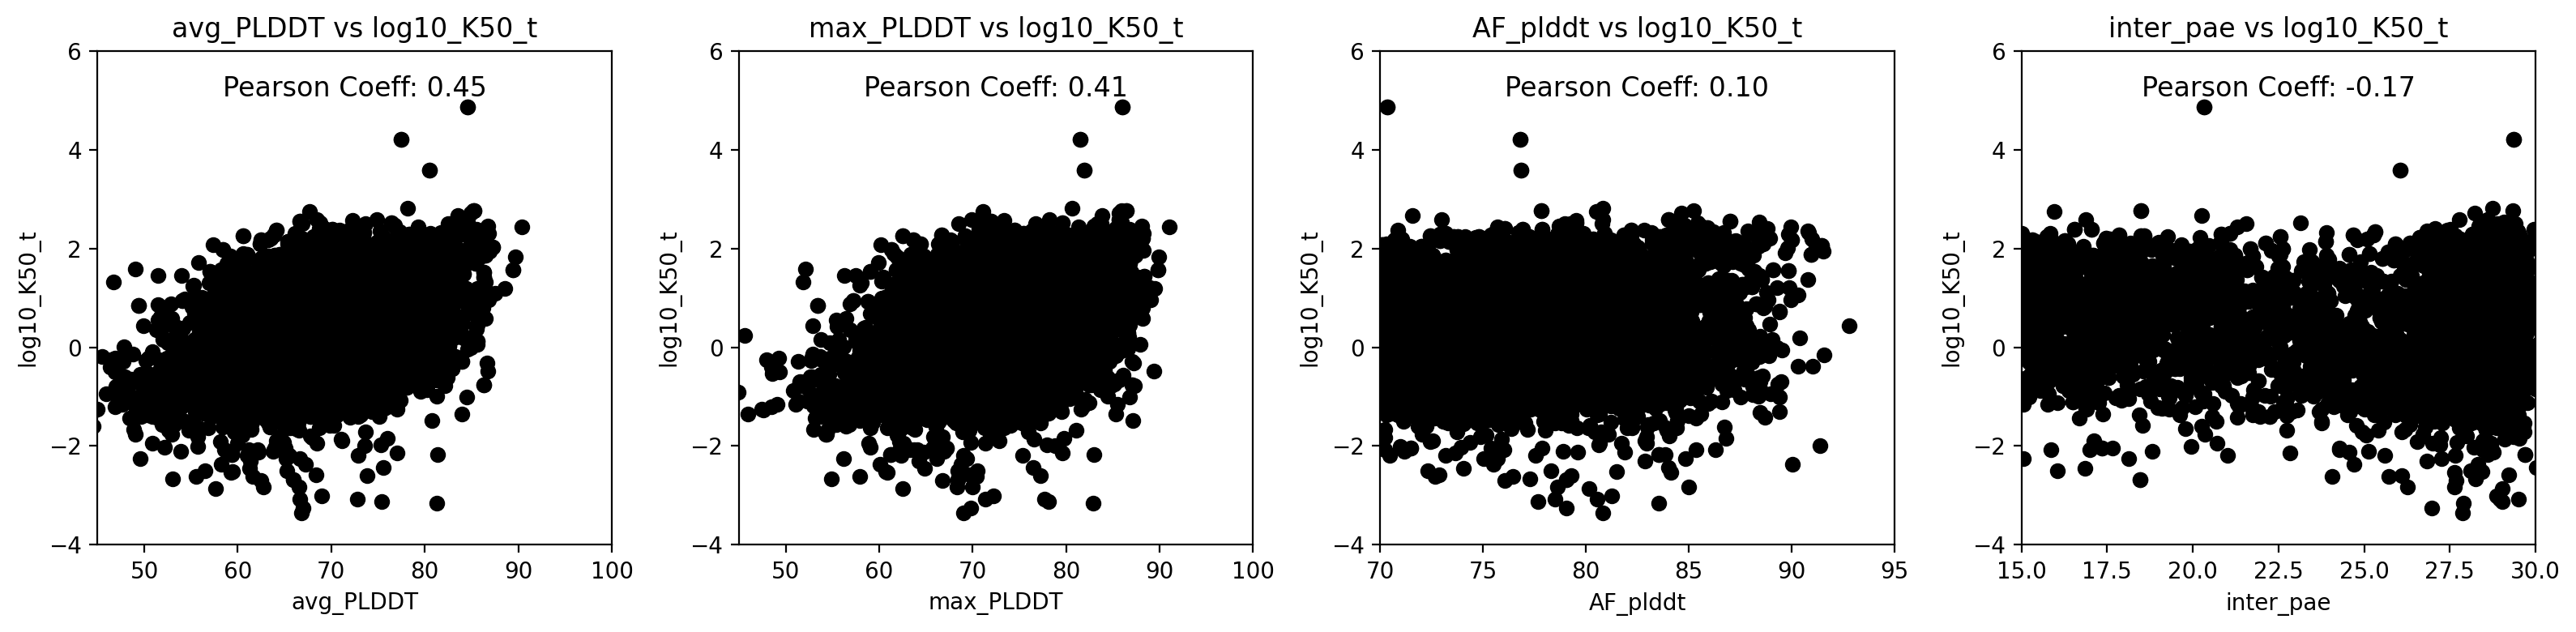

In [73]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def scatter_and_correlation(ax, df, x_column, y_column, label_x, label_y, xlim=None, ylim=None):
    # Drop rows with NaN values in the specified columns
    df_no_nan = df[[x_column, y_column]].dropna()

    # Scatter plot
    ax.scatter(df_no_nan[x_column].tolist(), df_no_nan[y_column].tolist(), color='black')
    ax.set_title(f'{label_x} vs {label_y}')
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)

    # Customize xlim and ylim if provided
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = pearsonr(df_no_nan[x_column], df_no_nan[y_column])

    # Add Pearson correlation coefficient to the plot
    ax.text(0.5, 0.95, f"Pearson Coeff: {correlation_coefficient:.2f}", transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='top', fontsize = 12)
    return correlation_coefficient

# Create a 1x4 subplot grid


# Create a 1x4 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot with customized xlim and ylim
a=scatter_and_correlation(axs[0], merged_df, 'avg_PLDDT', 'log10_K50_t', 'avg_PLDDT', 'log10_K50_t', xlim=(45, 100), ylim=(-4, 6))
b=scatter_and_correlation(axs[1], merged_df, 'max_PLDDT', 'log10_K50_t', 'max_PLDDT', 'log10_K50_t', xlim=(45, 100),   ylim=(-4, 6))
c=scatter_and_correlation(axs[2], merged_df, 'AF_plddt', 'log10_K50_t', 'AF_plddt', 'log10_K50_t', xlim=(70, 95),   ylim=(-4, 6))
d=scatter_and_correlation(axs[3], merged_df, 'inter_pae', 'log10_K50_t', 'inter_pae', 'log10_K50_t', xlim=(15, 30),  ylim=(-4, 6))


K_t = [a,b,c,d]
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()



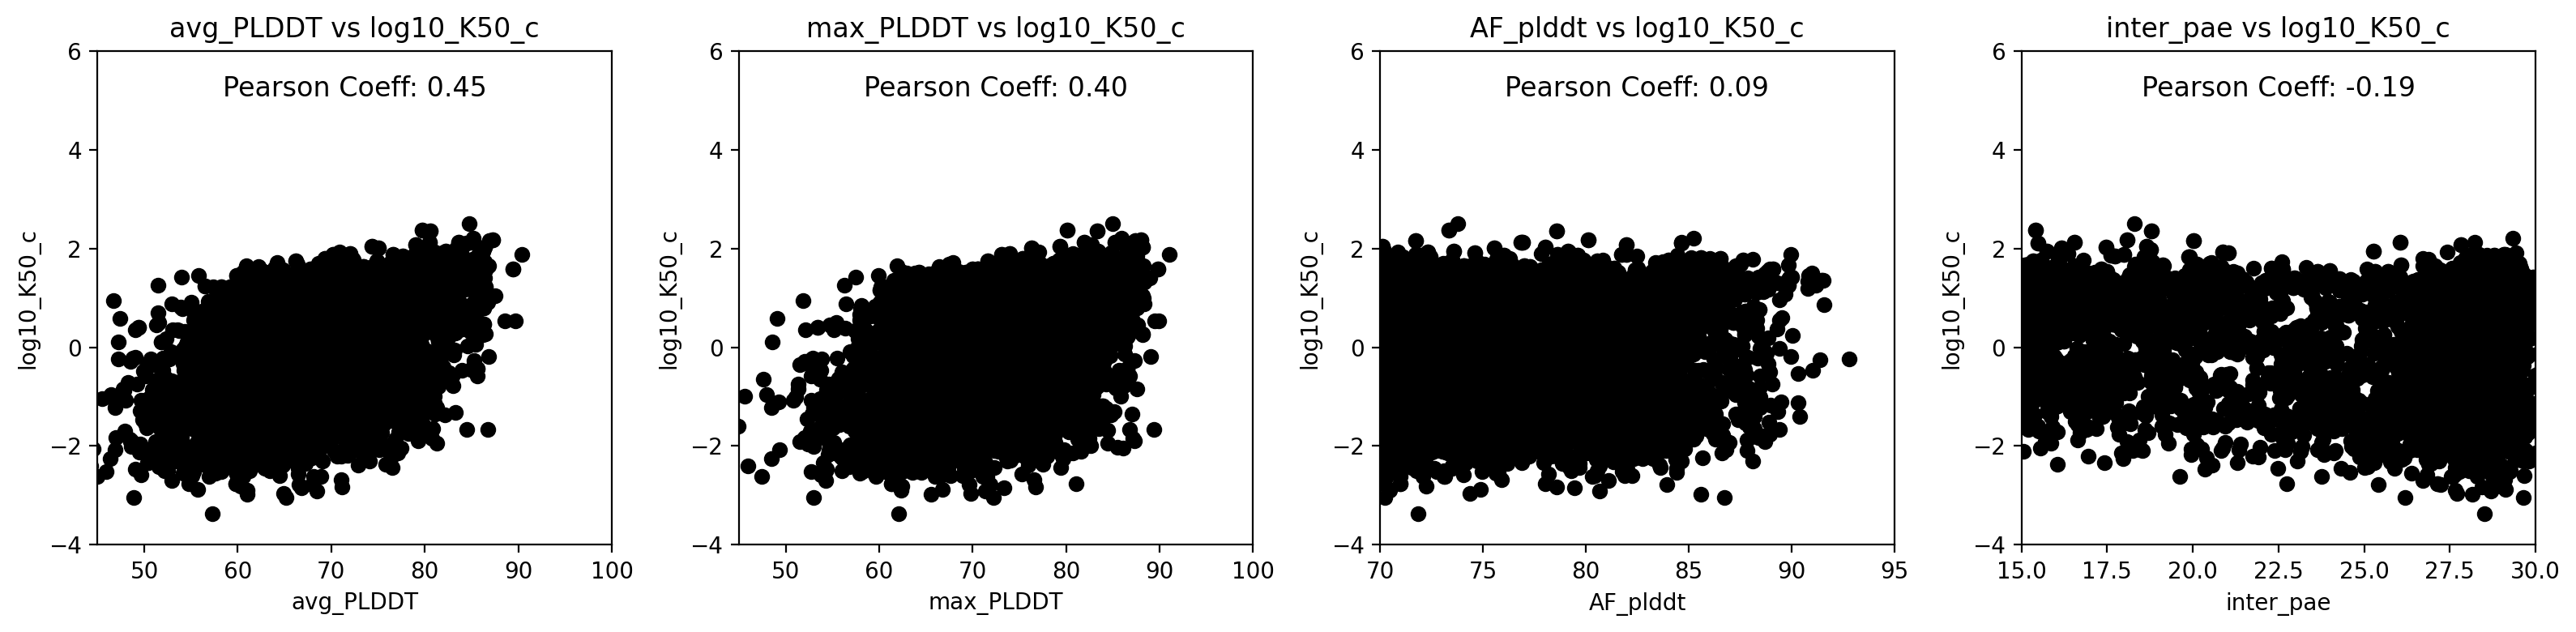

In [74]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot
a=scatter_and_correlation(axs[0], merged_df, 'avg_PLDDT', 'log10_K50_c', 'avg_PLDDT', 'log10_K50_c', xlim=(45, 100),  ylim=(-4, 6))
b=scatter_and_correlation(axs[1], merged_df, 'max_PLDDT', 'log10_K50_c', 'max_PLDDT', 'log10_K50_c', xlim=(45, 100),  ylim=(-4, 6))
c=scatter_and_correlation(axs[2], merged_df, 'AF_plddt', 'log10_K50_c', 'AF_plddt', 'log10_K50_c', xlim=(70, 95),  ylim=(-4, 6))
d=scatter_and_correlation(axs[3], merged_df, 'inter_pae', 'log10_K50_c', 'inter_pae', 'log10_K50_c', xlim=(15, 30), ylim=(-4, 6))


K_c = [a,b,c,d]
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()


In [75]:
# df_activity = pd.read_csv('230627_K50dG_dmsv2_refined.csv')
# df_activity = df_activity[['name', 'log10_K50_t', 'log10_K50_c', 'deltaG_t', 'deltaG_c', 'deltaG', 'deltaG_95CI']]

# # Filtering based on the conditions
# filtered_df = df_activity[

#         (df_activity['deltaG'] >= -1) & 
#         (df_activity['deltaG'] <= 5) &
#         (df_activity['deltaG_95CI'] <= 0.5)&
        
#         (df_activity['deltaG_t'] >= -1) & 
#         (df_activity['deltaG_t'] <= 5) &
        
        
#         (df_activity['deltaG_c'] >= -1) & 
#         (df_activity['deltaG_c'] <= 5)]


In [76]:

# data = []

# # Read the data from the file and append it to the list
# with open("raw.txt") as file:
#     for line in file:
#         name, plddt, pae_intra, pae_inter, kc, kt = line.rstrip().split(" ")
#         tmp = name.split("_")
#         ID, method = "_".join(tmp[:2]), "_".join(tmp[2:])
        
#         data.append({
#             "ID": ID,
#             "method": method,
#             "name": name,
#             "AF_plddt": float(plddt),
#             "intra_pae": float(pae_intra),
#             "inter_pae": float(pae_inter),
#             "kc": float(kc),
#             "kt": float(kt)
#         })

# # Create a DataFrame from the list
# df_raw = pd.DataFrame(data)
# print(len(df_raw))

# df_af = df_raw[(df_raw['AF_plddt'] > 70) & (df_raw['inter_pae'] > 15)][['name','AF_plddt', 'inter_pae']]

# print(len(df_af))
        
# filtered_df = pd.merge(df_af, filtered_df, on='name', how='left')

In [77]:
# merged_df = pd.merge(df_plddt, filtered_df[['name', 'log10_K50_t', 'log10_K50_c', 'deltaG_t', 'deltaG_c', 'deltaG', 'AF_plddt', 'inter_pae']], on='name', how='left')

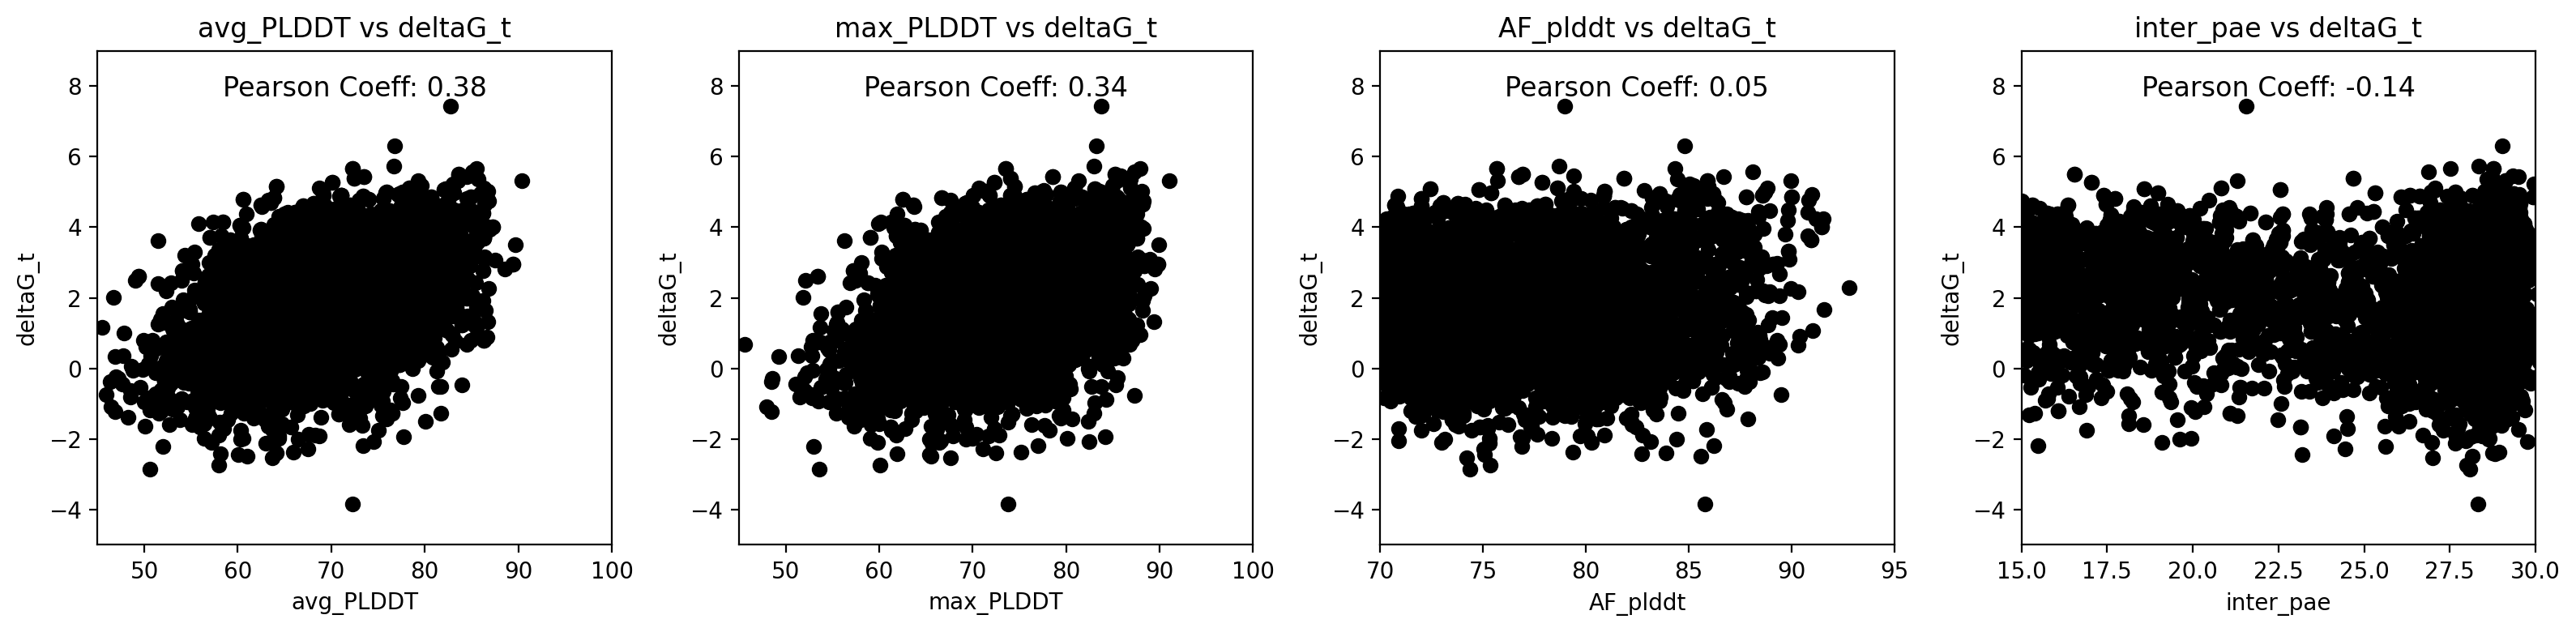

In [78]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot
a=scatter_and_correlation(axs[0], merged_df, 'avg_PLDDT', 'deltaG_t', 'avg_PLDDT', 'deltaG_t', xlim=(45, 100), ylim=(-5,9))
b=scatter_and_correlation(axs[1], merged_df, 'max_PLDDT', 'deltaG_t', 'max_PLDDT', 'deltaG_t', xlim=(45, 100),ylim=(-5,9))
c=scatter_and_correlation(axs[2], merged_df, 'AF_plddt', 'deltaG_t', 'AF_plddt', 'deltaG_t', xlim=(70, 95),  ylim=(-5,9))
d=scatter_and_correlation(axs[3], merged_df, 'inter_pae', 'deltaG_t', 'inter_pae', 'deltaG_t', xlim=(15, 30),  ylim=(-5,9))


G_t = [a,b,c,d]
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()



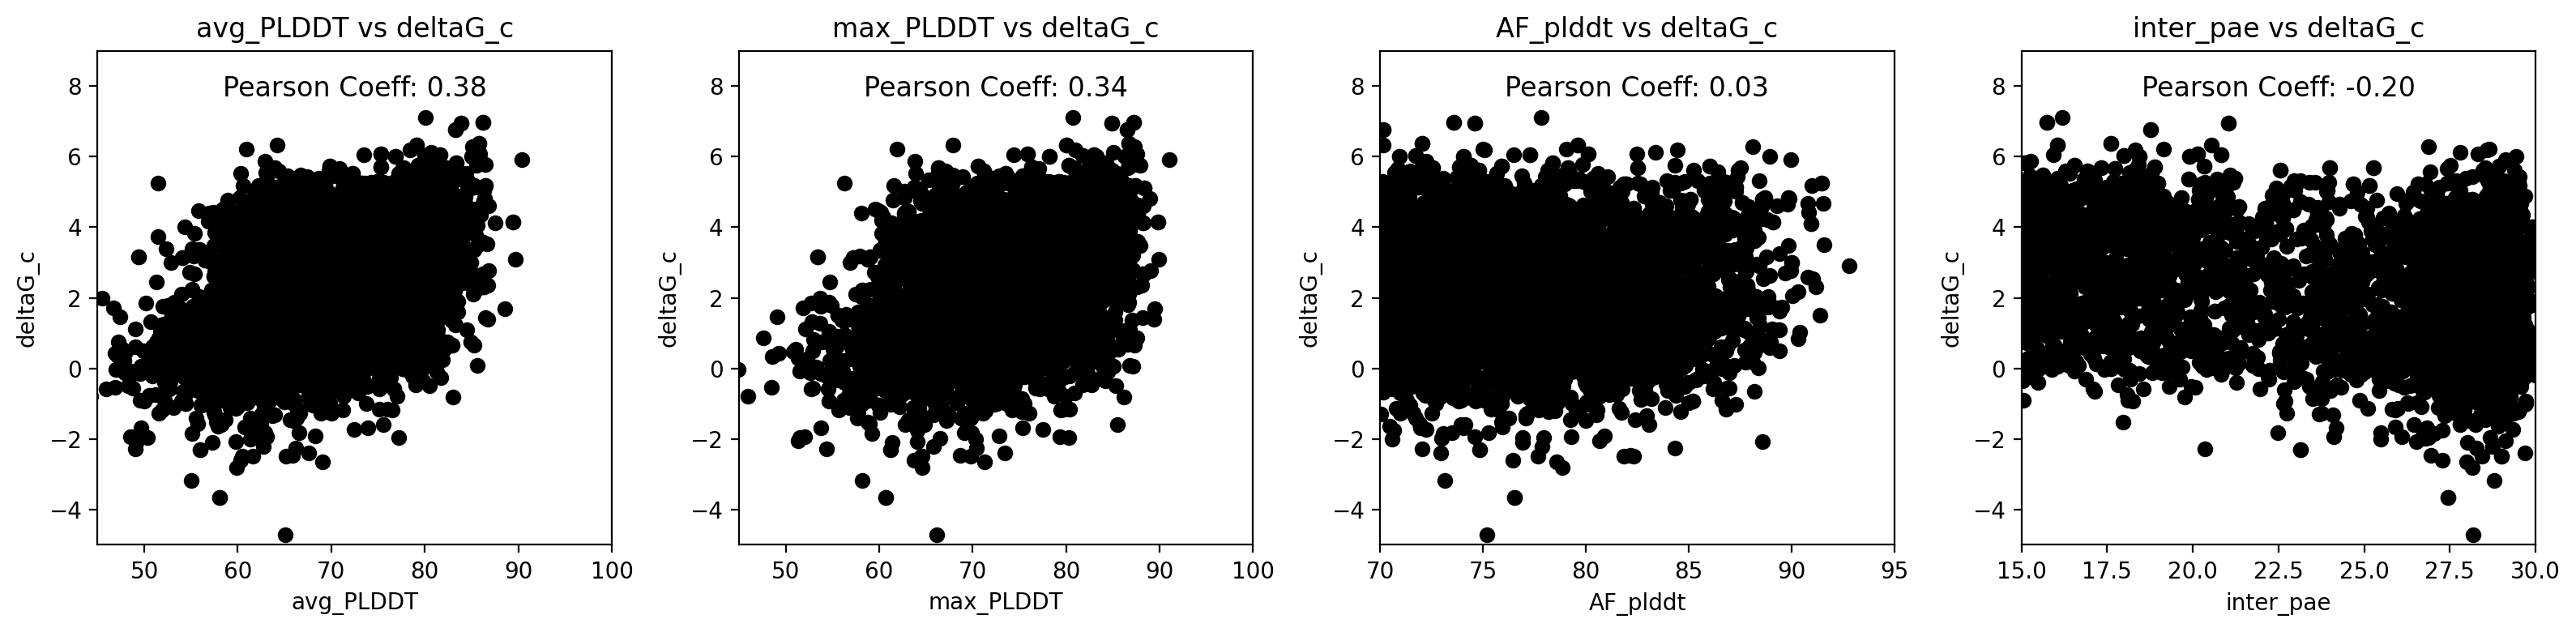

In [79]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot
a=scatter_and_correlation(axs[0], merged_df, 'avg_PLDDT', 'deltaG_c', 'avg_PLDDT', 'deltaG_c',  xlim=(45, 100),ylim=(-5,9))
b=scatter_and_correlation(axs[1], merged_df, 'max_PLDDT', 'deltaG_c', 'max_PLDDT', 'deltaG_c',  xlim=(45, 100), ylim=(-5,9))
c=scatter_and_correlation(axs[2], merged_df, 'AF_plddt', 'deltaG_c', 'AF_plddt', 'deltaG_c' , xlim=(70, 95),  ylim=(-5,9))
d=scatter_and_correlation(axs[3], merged_df, 'inter_pae', 'deltaG_c', 'inter_pae', 'deltaG_c', xlim=(15, 30), ylim=(-5,9))

G_c = [a,b,c,d]
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()



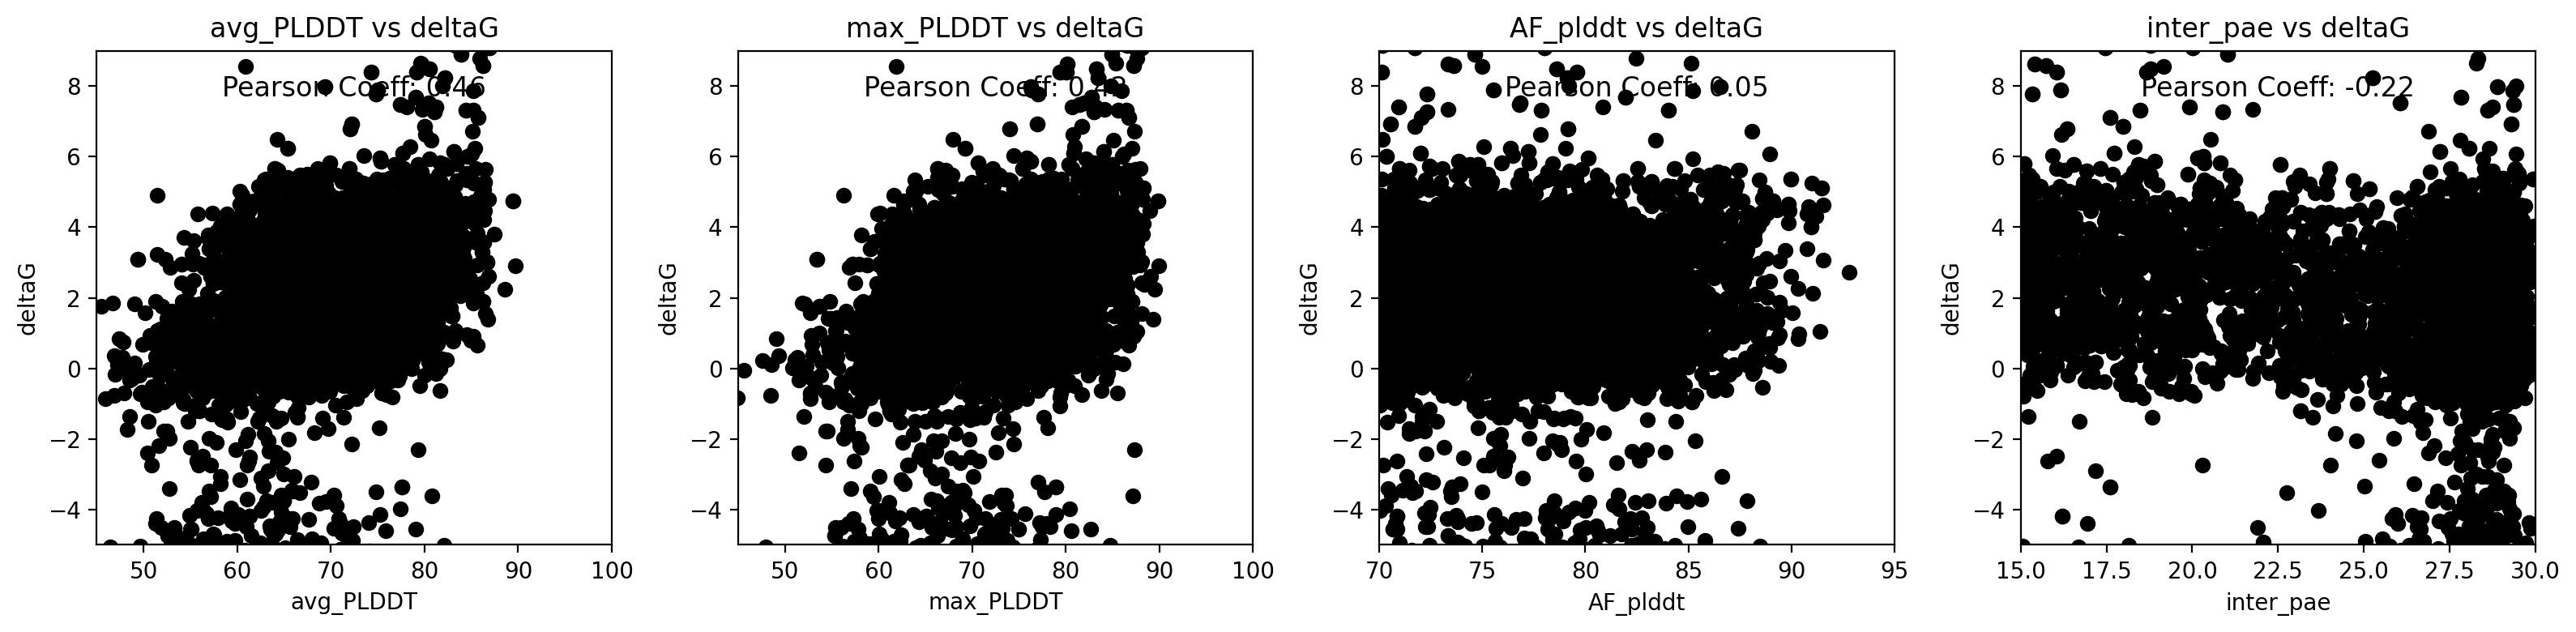

In [80]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot
a=scatter_and_correlation(axs[0], merged_df, 'avg_PLDDT', 'deltaG', 'avg_PLDDT', 'deltaG', xlim=(45, 100), ylim=(-5,9))
b=scatter_and_correlation(axs[1], merged_df, 'max_PLDDT', 'deltaG', 'max_PLDDT', 'deltaG', xlim=(45, 100),ylim=(-5,9))
c=scatter_and_correlation(axs[2], merged_df, 'AF_plddt', 'deltaG', 'AF_plddt', 'deltaG', xlim=(70, 95), ylim=(-5,9))
d=scatter_and_correlation(axs[3], merged_df, 'inter_pae', 'deltaG', 'inter_pae', 'deltaG', xlim=(15, 30),  ylim=(-5,9))

G=[a,b,c,d]
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()


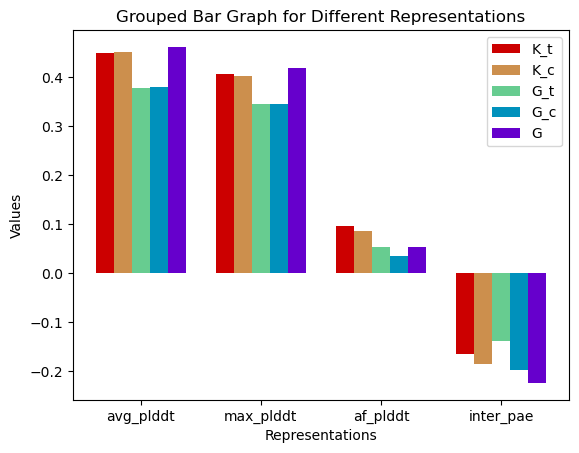

In [81]:
num_groups = len(K_t)
bar_width = 0.15
index = np.arange(num_groups)

# Rainbow colormap

rainbow_colors = plt.cm.rainbow(np.linspace(1, 0, 5))
rainbow_colors = rainbow_colors[:, :3] * 0.8  # Adjust saturation


# Create grouped bar graph with rainbow colors
plt.bar(index - 2*bar_width, K_t, bar_width, label='K_t', color=rainbow_colors[0])
plt.bar(index - bar_width, K_c, bar_width, label='K_c', color=rainbow_colors[1])
plt.bar(index, G_t, bar_width, label='G_t', color=rainbow_colors[2])
plt.bar(index + bar_width, G_c, bar_width, label='G_c', color=rainbow_colors[3])
plt.bar(index + 2*bar_width, G, bar_width, label='G', color=rainbow_colors[4])

# Customize the plot
plt.xlabel('Representations')
plt.ylabel('Values')
plt.title('Grouped Bar Graph for Different Representations')
plt.xticks(index, ['avg_plddt', 'max_plddt', 'af_plddt', 'inter_pae'])
plt.legend()

# Show the plot
plt.show()

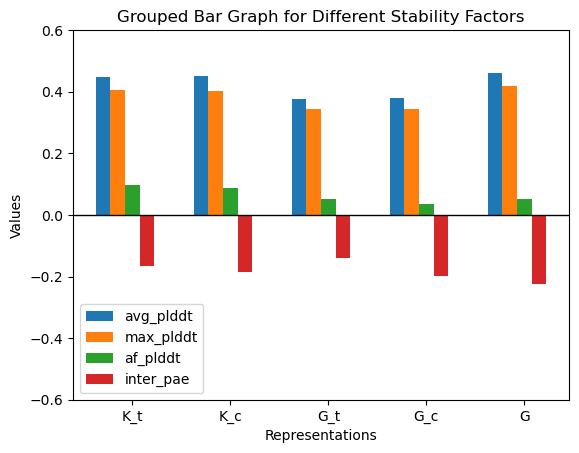

In [82]:
import numpy as np
import matplotlib.pyplot as plt

num_groups = 5
bar_width = 0.15
index = np.arange(num_groups)

# Rainbow colormap
data = np.array([K_t, K_c, G_t, G_c, G])

# Create grouped bar graph with pastel colors
plt.bar(index - 2 * bar_width, data[:, 0], bar_width, label='avg_plddt')
plt.bar(index - bar_width, data[:, 1], bar_width, label='max_plddt')
plt.bar(index, data[:, 2], bar_width, label='af_plddt')
plt.bar(index + bar_width, data[:, 3], bar_width, label='inter_pae')

# Draw a black line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Customize the plot
plt.xlabel('Representations')
plt.ylabel('Values')
plt.ylim([-0.6, 0.6])
plt.title('Grouped Bar Graph for Different Stability Factors')
plt.xticks(index, ['K_t', 'K_c', 'G_t', 'G_c', 'G'])
plt.legend()

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


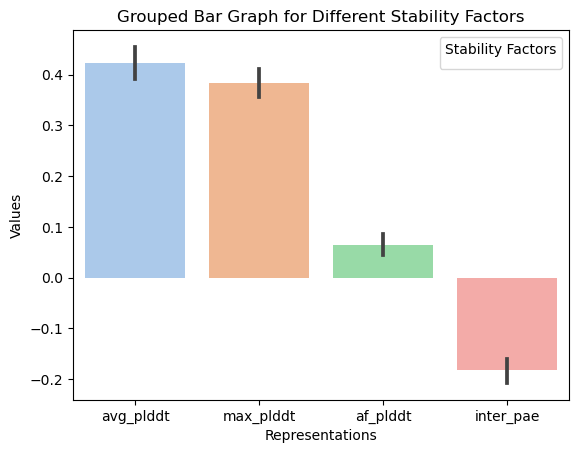

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the Seaborn style to use pastel colors
sns.set_palette(sns.color_palette("pastel"))

num_groups = 5
bar_width = 0.15
index = np.arange(num_groups)

# Rainbow colormap
data = np.array([K_t, K_c, G_t, G_c, G])

# Create a DataFrame for Seaborn
df = pd.DataFrame(data, index=['K_t', 'K_c', 'G_t', 'G_c', 'G'], columns=['avg_plddt', 'max_plddt', 'af_plddt', 'inter_pae'])

# Create grouped bar graph with pastel colors using Seaborn
ax = sns.barplot(data=df, palette='pastel')

# Customize the plot
ax.set(xlabel='Representations', ylabel='Values')
ax.set_title('Grouped Bar Graph for Different Stability Factors')
ax.legend(title='Stability Factors', bbox_to_anchor=(1, 1))

plt.show()


## 2. ESMfold predcition (full sequence)

In [84]:
import pandas as pd
from ast import literal_eval

# Sample DataFrame
df_plddt = pd.read_csv('dmsv2_aa_seq_all_4_single_sequence_plddt.csv')[:-1]
df_plddt['PLDDT'] = df_plddt['PLDDT'].apply(literal_eval)
df_plddt['PLDDT'] = df_plddt['PLDDT'].apply(lambda x: x[0])

In [85]:
df_activity = pd.read_csv('dataset/230627_K50dG_dmsv2_refined.csv')
df_activity = df_activity[['name', 'log10_K50_t', 'log10_K50_c', 'deltaG_t', 'deltaG_c', 'deltaG', 'deltaG_95CI']]

# Filtering based on the conditions
# filtered_df = df_activity[
#     (
#         (df_activity['deltaG'] >= -1) & 
#         (df_activity['deltaG'] <= 5) &
#         (df_activity['deltaG_95CI'] <= 0.5) 
#     )
# ]


filtered_df = df_activity

In [86]:

data = []

# Read the data from the file and append it to the list
with open("raw.txt") as file:
    for line in file:
        name, plddt, pae_intra, pae_inter, kc, kt = line.rstrip().split(" ")
        tmp = name.split("_")
        ID, method = "_".join(tmp[:2]), "_".join(tmp[2:])
        
        data.append({
            "ID": ID,
            "method": method,
            "name": name,
            "AF_plddt": float(plddt),
            "intra_pae": float(pae_intra),
            "inter_pae": float(pae_inter),
            "kc": float(kc),
            "kt": float(kt)
        })

# Create a DataFrame from the list
df_raw = pd.DataFrame(data)
print(len(df_raw))

df_af = df_raw[(df_raw['AF_plddt'] > 70) & (df_raw['inter_pae'] > 15)][['name','AF_plddt', 'inter_pae']]

print(len(df_af))
        
filtered_df = pd.merge(df_af, filtered_df, on='name', how='left')

40477
10213


In [87]:
len(filtered_df)

11587

In [88]:
merged_df = pd.merge(df_plddt, filtered_df[['name', 'log10_K50_t', 'log10_K50_c', 'deltaG_t', 'deltaG_c', 'deltaG', 'AF_plddt', 'inter_pae']], on='name', how='left')

In [89]:
filtered_df['log10_K50_t'].tolist()

[1.1482804490604996,
 1.1482804490604996,
 1.3453943035918705,
 1.2397202529313829,
 -0.8375334369243902,
 0.9380860409782888,
 0.0269350318262572,
 0.3729866812386191,
 -0.9304871075013286,
 0.9238738456320474,
 1.1584492822113128,
 1.1584492822113128,
 -1.0040423495347062,
 -0.164129399049105,
 -0.164129399049105,
 -6.157579727543782,
 1.3371587340355424,
 -1.1228792614784582,
 0.200938909454573,
 1.9377534466998003,
 1.9377534466998003,
 1.3027813221258977,
 -0.1400609102364183,
 0.5883459239322798,
 -1.251591167963902,
 1.0776783514870325,
 1.3576946612688785,
 -1.808476896302932,
 -0.327735489430046,
 -0.3967372081263929,
 -1.1251940871687311,
 -0.2633777121007977,
 -0.2827195573996728,
 1.6821588776398584,
 1.3258368603572888,
 -1.0784943073798705,
 -0.98173426788368,
 -0.98173426788368,
 0.6873828617108138,
 0.6873828617108138,
 -0.7414491813258479,
 0.5495468213825344,
 -0.6162838594574196,
 0.4742357588019669,
 1.2447459678300548,
 1.2447459678300548,
 0.430636044912656,
 -0.2

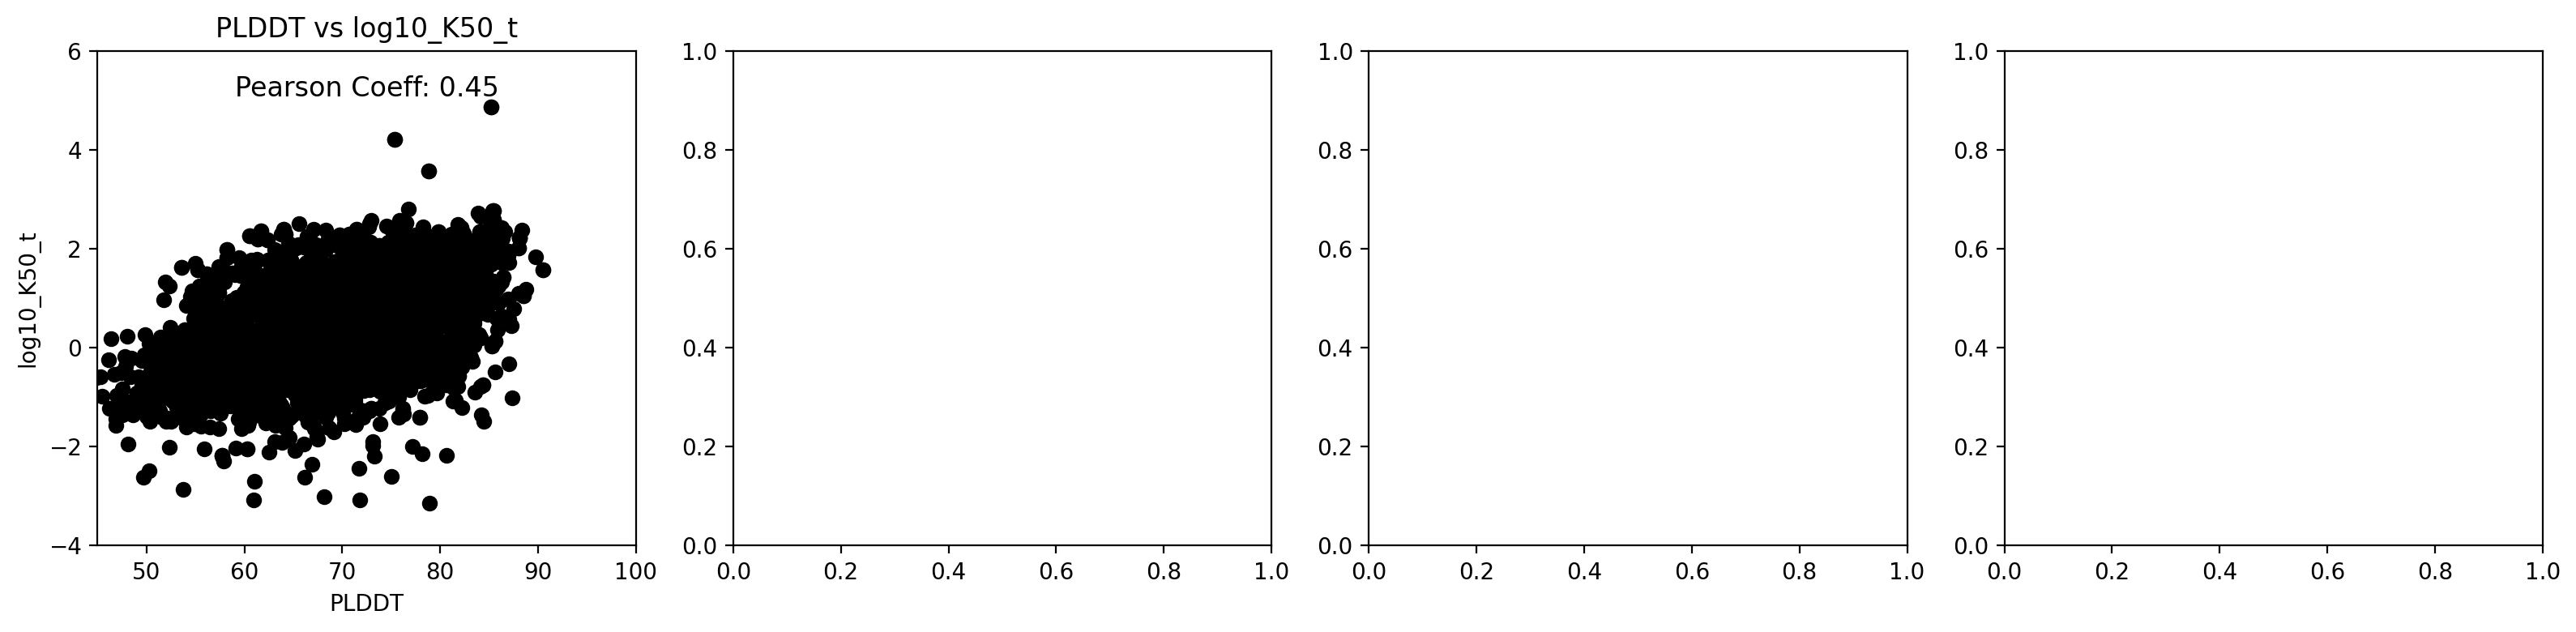

In [90]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def scatter_and_correlation(ax, df, x_column, y_column, label_x, label_y, xlim=None, ylim=None):
    # Drop rows with NaN values in the specified columns
    df_no_nan = df[[x_column, y_column]].dropna()

    # Scatter plot
    ax.scatter(df_no_nan[x_column].tolist(), df_no_nan[y_column].tolist(), color='black')
    ax.set_title(f'{label_x} vs {label_y}')
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)

    # Customize xlim and ylim if provided
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = pearsonr(df_no_nan[x_column], df_no_nan[y_column])

    # Add Pearson correlation coefficient to the plot
    ax.text(0.5, 0.95, f"Pearson Coeff: {correlation_coefficient:.2f}", transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='top', fontsize = 12)
    return correlation_coefficient

# Create a 1x4 subplot grid


# Create a 1x4 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot with customized xlim and ylim
s1=scatter_and_correlation(axs[0], merged_df, 'PLDDT', 'log10_K50_t', 'PLDDT', 'log10_K50_t', xlim=(45, 100), ylim=(-4, 6))

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()



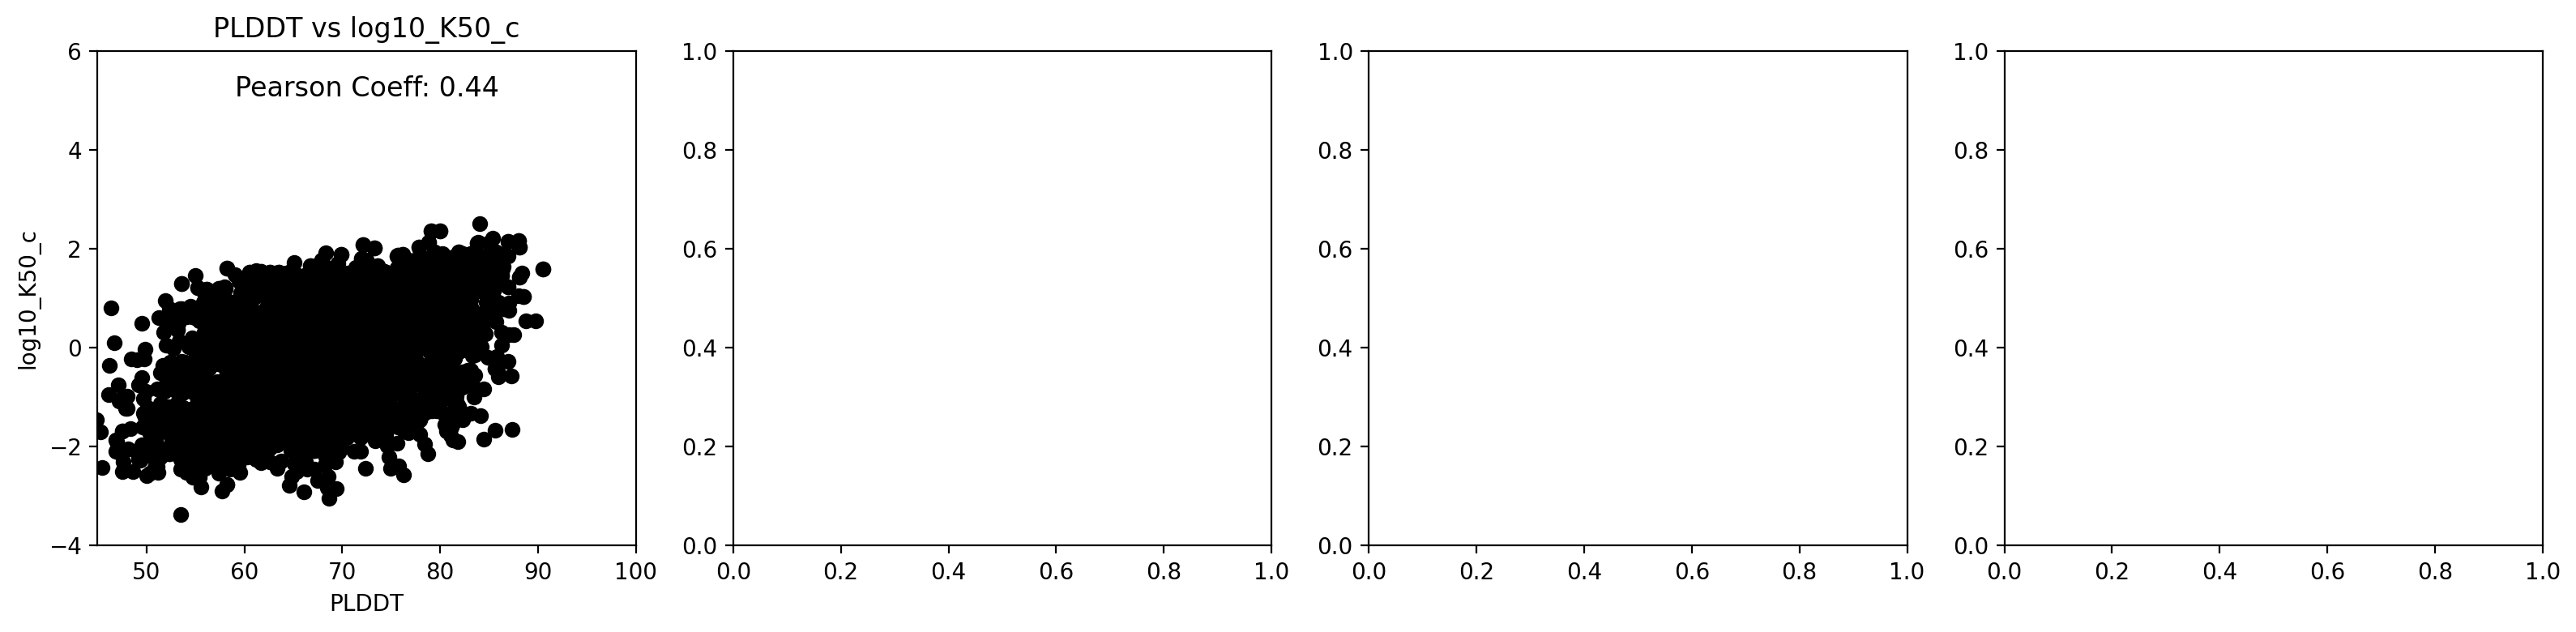

In [91]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot
s2=scatter_and_correlation(axs[0], merged_df, 'PLDDT', 'log10_K50_c', 'PLDDT', 'log10_K50_c', xlim=(45, 100),  ylim=(-4, 6))

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()


In [92]:
# merged_df = pd.merge(df_plddt, filtered_df[['name', 'log10_K50_t', 'log10_K50_c', 'deltaG_t', 'deltaG_c', 'deltaG', 'AF_plddt', 'inter_pae']], on='name', how='left')

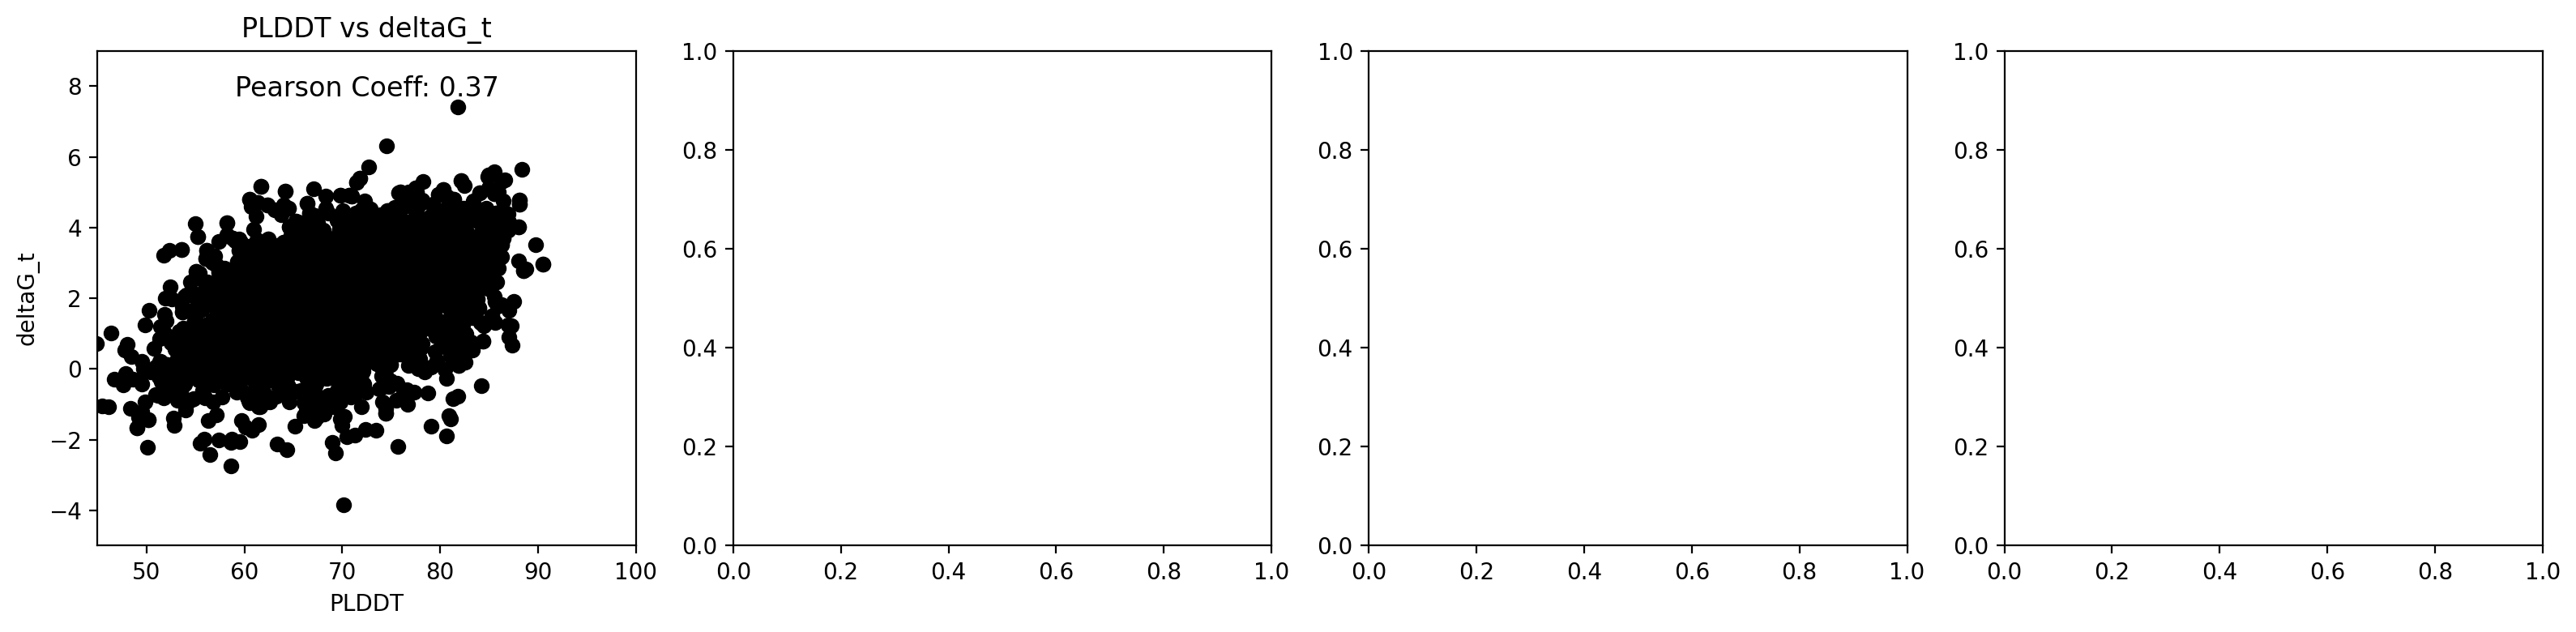

In [93]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot
s3=scatter_and_correlation(axs[0], merged_df, 'PLDDT', 'deltaG_t', 'PLDDT', 'deltaG_t', xlim=(45, 100), ylim=(-5,9))

plt.tight_layout()

# Show the plot
plt.show()



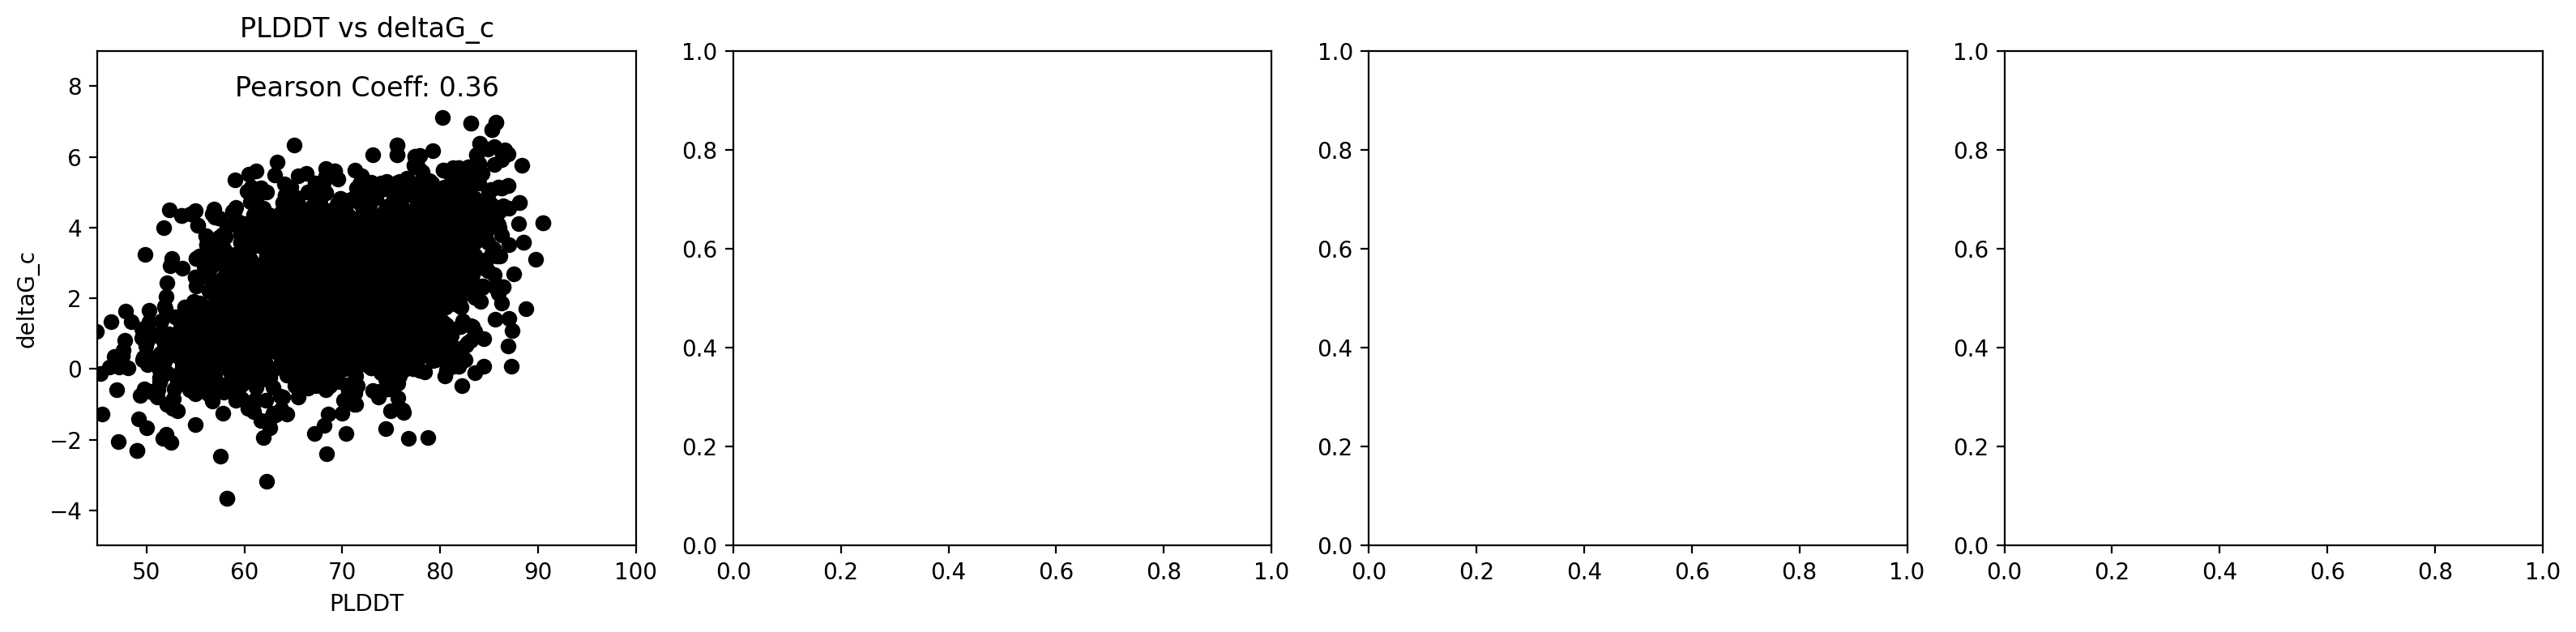

In [94]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot
s4=scatter_and_correlation(axs[0], merged_df, 'PLDDT', 'deltaG_c', 'PLDDT', 'deltaG_c',  xlim=(45, 100),ylim=(-5,9))


plt.tight_layout()

# Show the plot
plt.show()



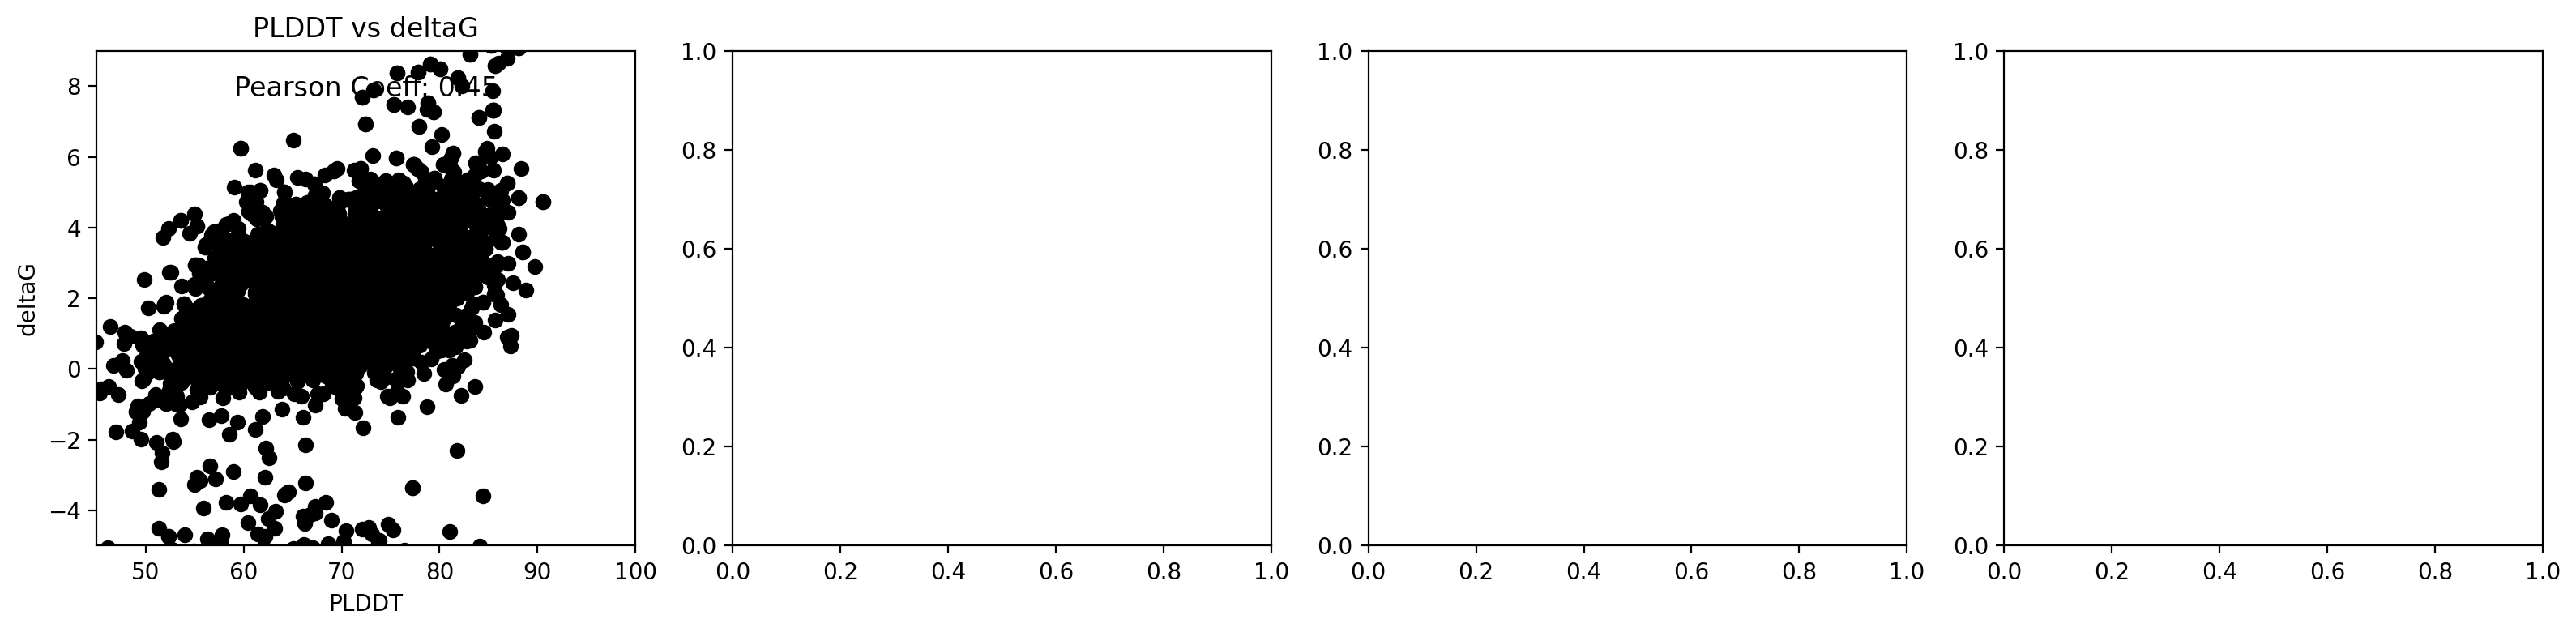

In [95]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

# Example usage for each subplot
s5=scatter_and_correlation(axs[0], merged_df, 'PLDDT', 'deltaG', 'PLDDT', 'deltaG', xlim=(45, 100), ylim=(-5,9))

plt.tight_layout()

# Show the plot
plt.show()


In [96]:
full_seq_ESMFold = [s1,s2,s3,s4,s5]

In [97]:

full_seq_ESMFold = [s1,s2,s3,s4,s5]

data = [K_t, K_c, G_t, G_c, G]

# Prepend values from full_seq_ESMFold to each list in data
for i in range(5):
    data[i] = np.insert(data[i], 0, full_seq_ESMFold[i])
    
data= np.array(data)

In [98]:
data[0]

array([ 0.44803939,  0.44888815,  0.40684113,  0.09597229, -0.16614102])

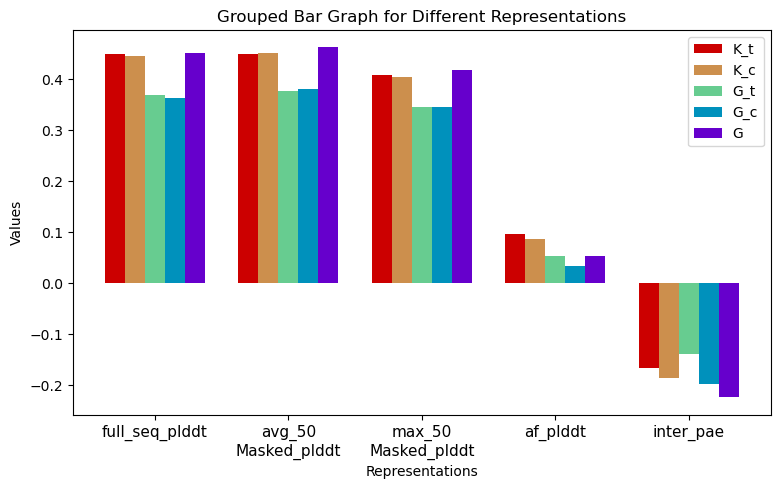

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the data defined somewhere
# K_t, K_c, G_t, G_c, G, num_groups, bar_width, index, rainbow_colors

# Set the figure size
fig = plt.figure(figsize=(9, 5))

# Create grouped bar graph with rainbow colors
plt.bar(index - 2*bar_width, data[0], bar_width, label='K_t', color=rainbow_colors[0])
plt.bar(index - bar_width, data[1], bar_width, label='K_c', color=rainbow_colors[1])
plt.bar(index, data[2], bar_width, label='G_t', color=rainbow_colors[2])
plt.bar(index + bar_width, data[3], bar_width, label='G_c', color=rainbow_colors[3])
plt.bar(index + 2*bar_width, data[4], bar_width, label='G', color=rainbow_colors[4])

# Customize the plot
plt.xlabel('Representations')
plt.ylabel('Values')
plt.title('Grouped Bar Graph for Different Representations')
plt.xticks(index, ['full_seq_plddt', 'avg_50\nMasked_plddt', 'max_50\nMasked_plddt', 'af_plddt', 'inter_pae'], fontsize= 11)
plt.legend()

# Show the plot
plt.show()


In [100]:
data

array([[ 0.44803939,  0.44888815,  0.40684113,  0.09597229, -0.16614102],
       [ 0.44380581,  0.45061732,  0.40254726,  0.08592301, -0.1861911 ],
       [ 0.36911643,  0.37699569,  0.34446451,  0.05285689, -0.14007857],
       [ 0.36232507,  0.3795157 ,  0.34379058,  0.03404228, -0.19782164],
       [ 0.44990335,  0.46150443,  0.4179786 ,  0.05182747, -0.2244279 ]])

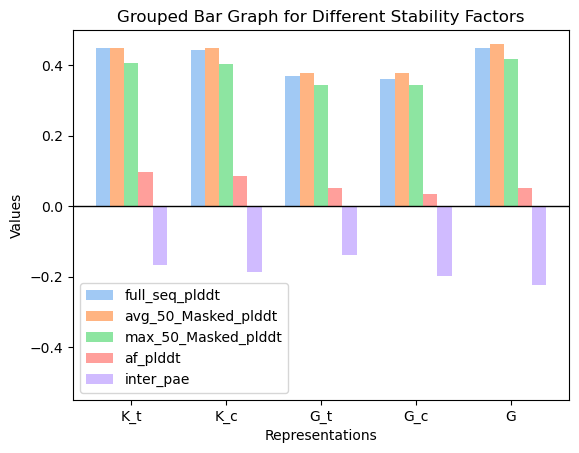

In [101]:
import numpy as np
import matplotlib.pyplot as plt

num_groups = 5
bar_width = 0.15
index = np.arange(num_groups)



# Create grouped bar graph with pastel colors
plt.bar(index - 2 * bar_width, data[:, 0], bar_width, label= 'full_seq_plddt')
plt.bar(index -  bar_width, data[:, 1], bar_width, label='avg_50_Masked_plddt')
plt.bar(index , data[:, 2], bar_width, label= 'max_50_Masked_plddt')
plt.bar(index+bar_width, data[:, 3], bar_width, label='af_plddt')
plt.bar(index + 2*bar_width, data[:, 4], bar_width, label='inter_pae')

# Draw a black line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Customize the plot
plt.xlabel('Representations')
plt.ylabel('Values')
plt.ylim([-0.55, 0.5])
plt.title('Grouped Bar Graph for Different Stability Factors')
plt.xticks(index, ['K_t', 'K_c', 'G_t', 'G_c', 'G'])
plt.legend()

# Show the plot
plt.show()

## 3. ProteinMPNN

In [195]:
len(os.listdir('dataset/af2_predicted'))

40529

In [210]:
import ast
import numpy as np

basedir = 'unconditional_MPNN_pssm_v_48_010.txt'
loaded_list = []

with open(basedir, 'r') as f:
    for line in f:
        try:
            item = ast.literal_eval(line.strip())
            loaded_list.append(item)
        except (ValueError, SyntaxError):
            # Handle the case where the line cannot be evaluated
            print(f"Skipping line: {line}")

In [211]:
len(loaded_list)

6810

In [212]:
df = pd.DataFrame(loaded_list, columns=['pdb_name','sequence', 'pssm', 'CE'])

In [213]:
len(df)

6810

In [214]:
df['pdb_name'] = df['pdb_name'].str.replace('_unrelaxed_model_1.pdb', '')

In [215]:
df.rename(columns={'pdb_name': 'name'}, inplace=True)

In [216]:
# merged_df

In [217]:
df_f1 = pd.merge(df, merged_df[['name', 'sequence', 'PLDDT', 'avg_PLDDT', 'max_PLDDT', 'log10_K50_t',
       'log10_K50_c', 'deltaG_t', 'deltaG_c', 'deltaG', 'AF_plddt',
       'inter_pae']], on='name', how='left')

In [218]:
df_f1 = df_f1.dropna(subset=['log10_K50_t'])

In [219]:
len(df_f1)

812

Pearson Correlation Coefficient: -0.2061655205544153


Text(0.5, 0, 'CE')

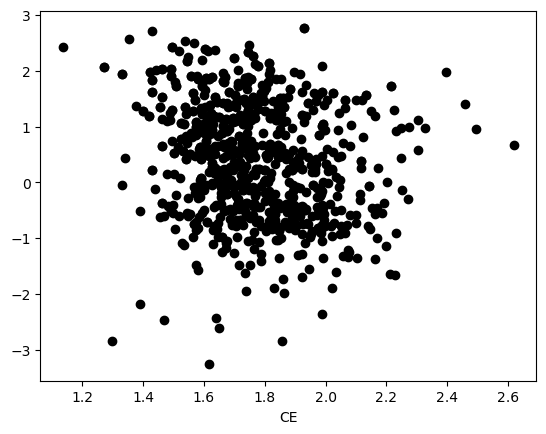

In [220]:
correlation_coefficient, _ = pearsonr(df_f1['CE'].tolist(), df_f1['log10_K50_t'].tolist())

# Print the correlation coefficient
print("Pearson Correlation Coefficient:", correlation_coefficient)

# Create a scatter plot
plt.scatter(df_f1['CE'].tolist(), df_f1['log10_K50_t'].tolist(), color='black')
plt.xlabel('CE')